In [17]:
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from joblib import dump, load

In [2]:
df = pd.read_csv('../../data/processed/WESAD/data_processed/30s/addon_feature_data.csv' ,index_col=0)
df.head()

,ACC_x_mean,ACC_y_mean,ACC_z_mean,net_acc_mean,net_acc_std,EDA_mean,EDA_std,EDA_slope,RESP_rate,RESP_regularity,...,EDA_slope_clipped,EDA_slope_log,EDA_slope_pos,eda_hr_interaction,eda_resp_ratio,hr_resp_interaction,hr_resp_z_interaction,hrv_composite,hrv_stress_index,arousal_index
0,39.628667,-46.246667,9.764000,62.469299,1.120992,0.523506,0.009367,-0.000265,21.327375,1.591487,...,-0.000265,-0.000265,0,34.746298,0.005886,1415.545722,-0.035662,96.253149,0.595642,741.047339
1,38.927333,-48.439333,6.083333,62.442314,0.428267,0.520051,0.018623,0.000048,22.168906,1.352590,...,0.000048,0.000048,1,40.870200,0.013768,1742.228749,0.007070,124.282730,0.976977,906.047629
2,38.919333,-47.006667,-0.914667,62.576766,1.166077,0.493109,0.007353,-0.000203,24.011434,1.809602,...,-0.000203,-0.000203,0,32.095491,0.004064,1562.857969,-1.403354,132.380562,0.676597,770.658757
3,49.157333,-18.907333,31.472000,62.762208,1.500866,0.470519,0.010338,-0.000283,20.909046,1.358827,...,-0.000283,-0.000283,0,30.942103,0.007608,1375.012643,0.164330,98.535106,0.650496,646.969837
4,46.228000,-39.174667,13.782000,62.674127,1.910619,0.442887,0.007276,-0.000196,22.165715,1.926374,...,-0.000196,-0.000196,0,33.749942,0.003777,1689.123832,-0.076409,116.329704,1.112837,748.091592


In [3]:
selected_feature = ['EDA_mean', 'EDA_std', 'RESP_rate', 'RESP_regularity', 'HR', 'SDNN',
       'pNN50', 'hr_diff', 'hr_center', 'hr_slope', 'hr_sdnn_ratio',
       'EDA_slope_clipped', 'hr_resp_interaction', 'hr_resp_z_interaction',
       'hrv_stress_index']

In [4]:
X = df[selected_feature]
y = df['focus_label']

In [5]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
y_pred = cross_val_predict(pipeline, X, y, cv=cv)

In [8]:
print(classification_report(y, y_pred, target_names=['Not Focus', 'Focus']))

              precision    recall  f1-score   support

   Not Focus       0.88      0.71      0.79       397
       Focus       0.80      0.93      0.86       495

    accuracy                           0.83       892
   macro avg       0.84      0.82      0.82       892
weighted avg       0.84      0.83      0.83       892



In [9]:
param_grid = {
    'clf__n_estimators': [50, 100, 150],
    'clf__max_depth': [None, 5, 10],
    'clf__min_samples_split': [2, 5],
}

In [10]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

In [11]:
grid_search.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 5, 10],
                         'clf__min_samples_split': [2, 5],
                         'clf__n_estimators': [50, 100, 150]},
             scoring='f1_macro', verbose=1)

In [12]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score (F1 macro):", grid_search.best_score_)

Best Parameters: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}
Best Score (F1 macro): 0.8290086083305461


In [13]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=50, random_state=42))
])

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
y_pred = cross_val_predict(model, X, y, cv=cv)

In [16]:
print(classification_report(y, y_pred, target_names=['Not Focus', 'Focus']))

              precision    recall  f1-score   support

   Not Focus       0.88      0.73      0.80       397
       Focus       0.81      0.92      0.86       495

    accuracy                           0.84       892
   macro avg       0.84      0.83      0.83       892
weighted avg       0.84      0.84      0.83       892



In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

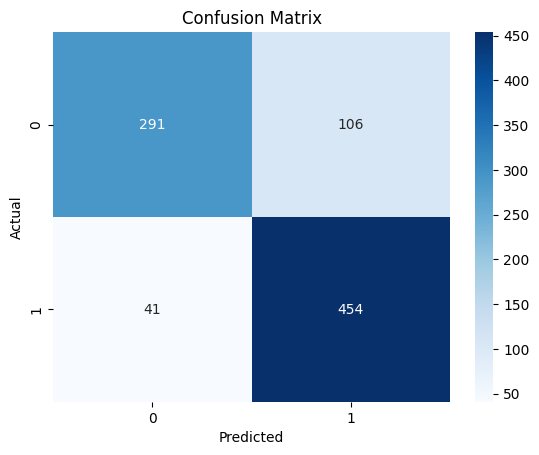

In [25]:
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()